In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch import nn

In [4]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [12, 12]

In [24]:
import numpy as np
import scipy
from scipy.interpolate import make_interp_spline
import seaborn as sns

from tqdm.notebook import tqdm, trange

# Create Pseudo Data

In [8]:
seed = 42
test_size = 0.2

In [9]:
X_var = 1
y_var = 0.01

In [10]:
num_features = 1
num_data = 10000

In [11]:
X = (2*np.random.rand(num_data, num_features)-1)*X_var
y_true = X[:, :1]**2
y_noise = np.random.randn(num_data, num_features)*y_var
y = y_true+y_noise

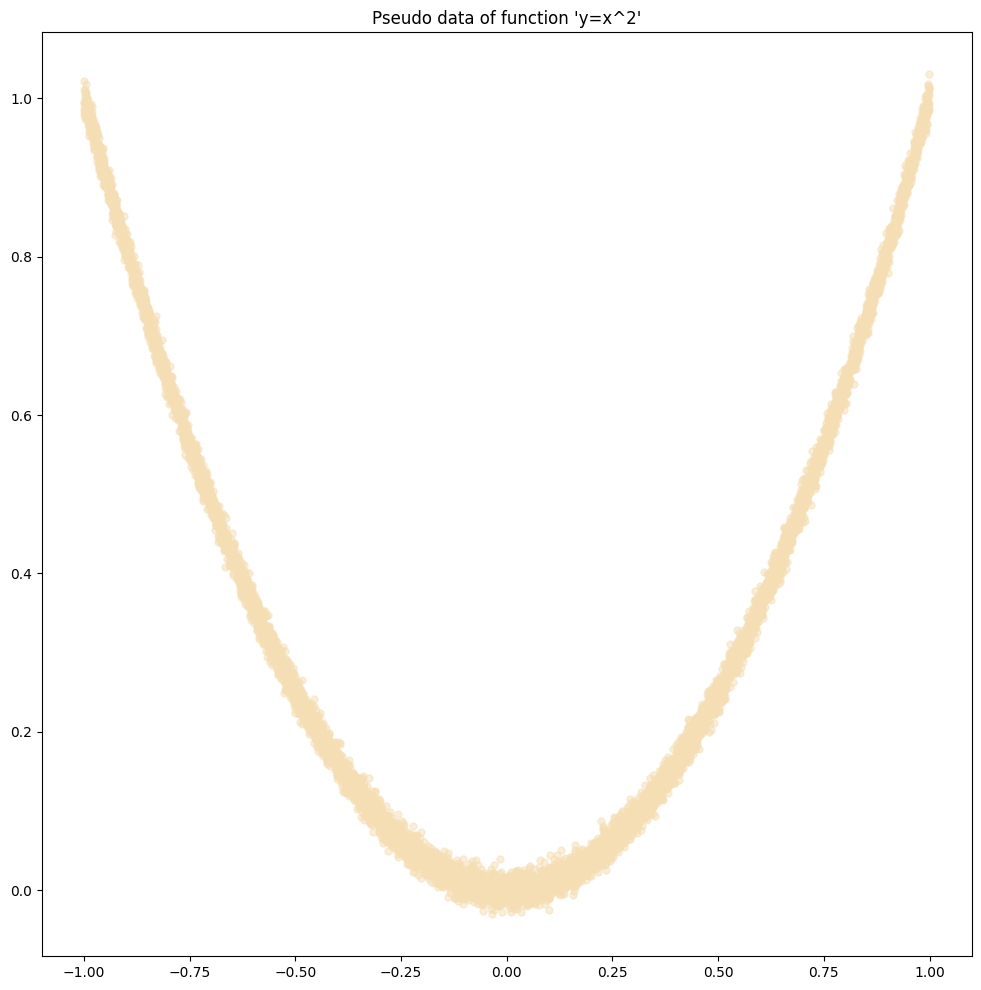

In [12]:
plt.scatter(X, y, c='wheat', alpha=0.5)
plt.title("Pseudo data of function 'y=x^2'")
plt.show()

In [13]:
plt.close()

# Create MLP Regressor to Learn a Proper Function

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [16]:
regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)

In [17]:
y_pred = regr.predict(X_test)
score = regr.score(X_test, y_test)

In [18]:
y_pred = np.expand_dims(y_pred, axis=1)

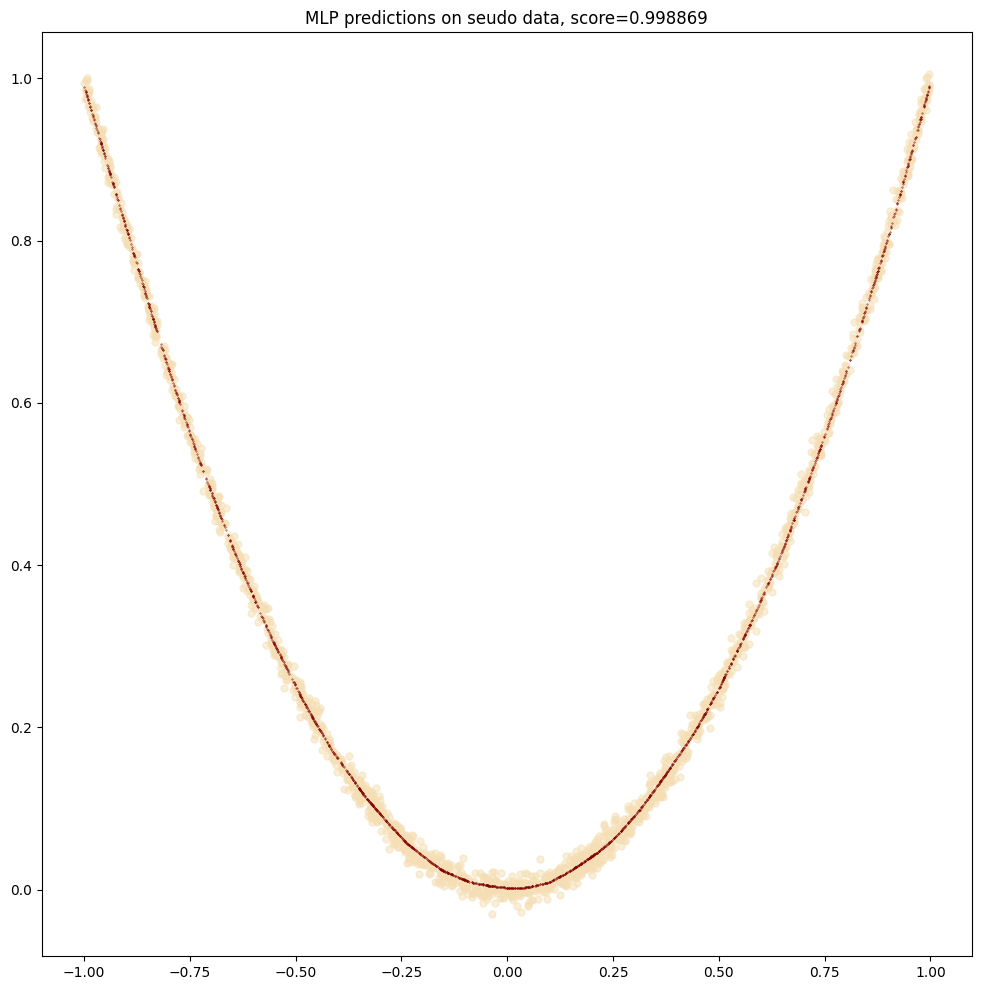

In [19]:
plt.scatter(X_test, y_test, c='wheat', alpha=0.5)
plt.scatter(X_test, y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:2f}")
plt.show()

In [20]:
plt.close()

# Learning with different number of noisy features

In [21]:
num_features_options = [1, 26, 51, 76, 101, 126, 151, 176, 201]

In [22]:
figure = plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

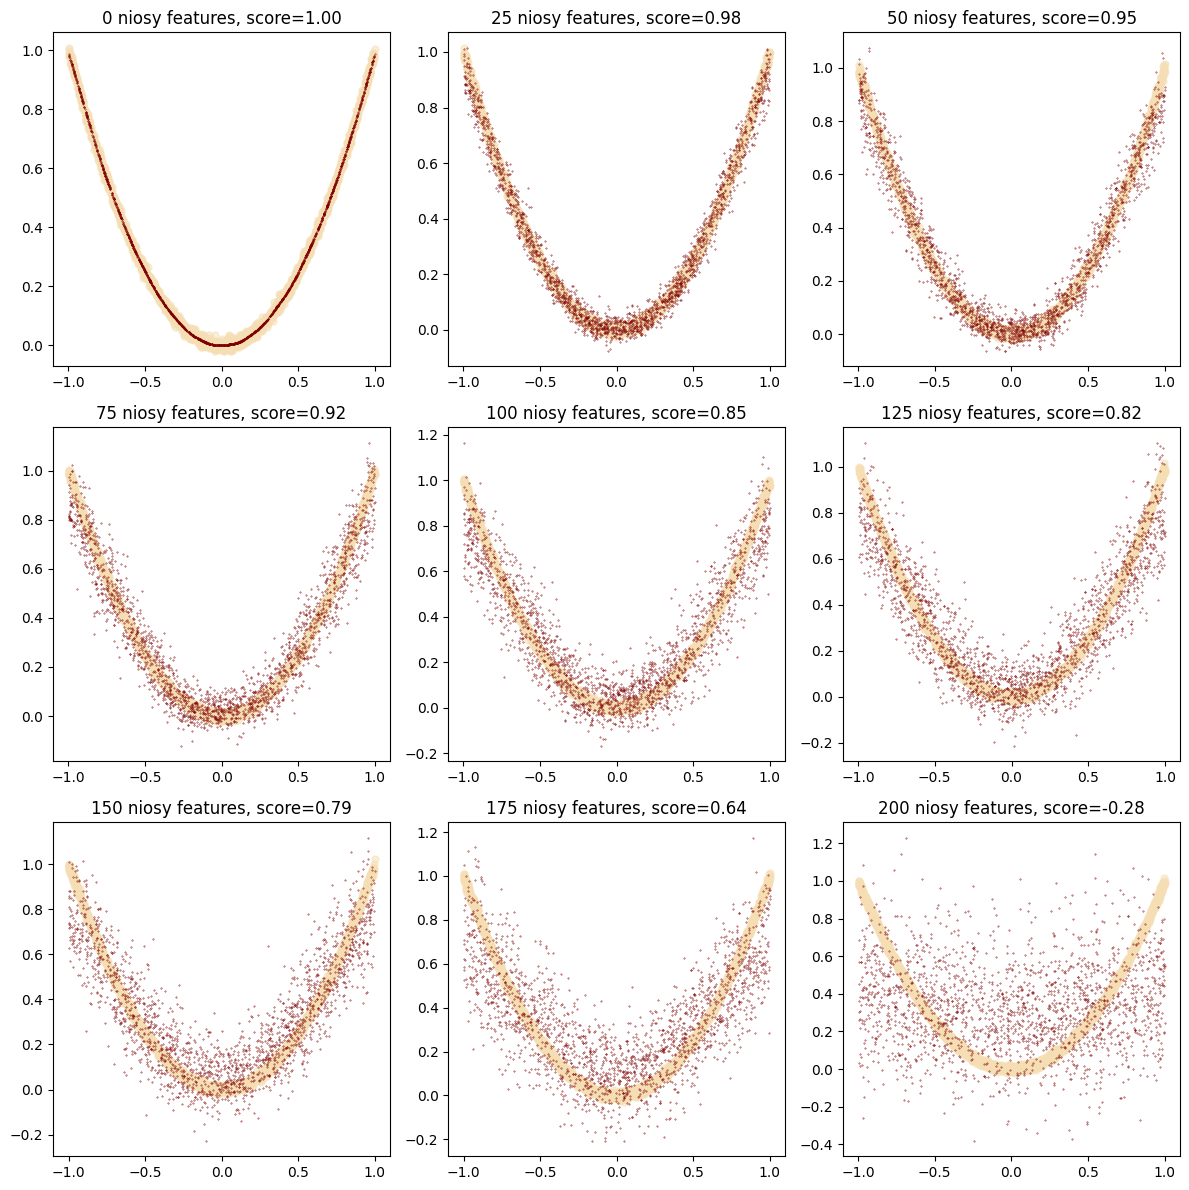

In [23]:
for ids, num_features in enumerate(num_features_options):
    X = (2*np.random.rand(num_data, num_features)-1)*X_var
    y_true = X[:, :1]**2
    y_noise = np.random.randn(num_data, 1)*y_var
    y = y_true+y_noise
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    score = regr.score(X_test, y_test)
    y_pred = np.expand_dims(y_pred, axis=1)
    
    ax = plt.subplot(math.ceil(len(num_features_options)/3), 3, ids+1)
    ax.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
    ax.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
    ax.set_title(f"{num_features-1} niosy features, score={score:.2f}")

plt.tight_layout()
# plt.savefig("../preliminary.png", dpi=300)
plt.show()

In [78]:
plt.rcParams['figure.figsize'] = [12, 4]
figure = plt.figure(figsize=(12, 4))
num_features_options = [1, 26, 51, 76, 101, 126, 151, 176, 201]

<Figure size 1200x400 with 0 Axes>

In [79]:
ya = []
for ids, num_features in enumerate(num_features_options):
    X = (2*np.random.rand(num_data, num_features)-1)*X_var
    y_true = X[:, :1]**2
    y_noise = np.random.randn(num_data, 1)*y_var
    y = y_true+y_noise
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    score = regr.score(X_test, y_test)
    y_pred = np.expand_dims(y_pred, axis=1)
    ya.append(score)

In [80]:
ya

[0.998754447989623,
 0.9769283188059529,
 0.9522409150842367,
 0.9241445045539493,
 0.8667666404852548,
 0.8090779595911746,
 0.7909060666353697,
 0.5588327333671601,
 -0.18645193310179442]

In [76]:
yas = [
    [0.9988356158936622,0.9770088225406417,0.9454882737216017,0.9147294891019538,0.8603364132618322,0.7818540863662804,0.7840129792659974,0.6461910443241008,-0.08150215458916144],
    [0.9987751881548305,0.9759906559215176,0.953305933965544,0.9237287414974831,0.8679543925928196,0.8152650051186462,0.765770983817425,0.6975295967287699,-0.26458696406061466],
    [0.9988427913245886,0.9773116549201569,0.9535161872862773,0.9135850110832925,0.8533361413625473,0.7815648739178427,0.7679246940221534,0.6183975064187108,-0.10879831064715306],
    [0.9988324605593394,0.9783111980207376,0.9458364408277753,0.9215708876768273,0.8698023547083901,0.8184649366287395,0.7876583197207148,0.6594190330792395,-0.002336200432020652],
    [0.9987990605503332,0.9776103827795103,0.9528011159011971,0.9102344010883092,0.8718922499641284,0.8276689372124579,0.8133654126896809,0.6974255461502575,0.12416357741591277],
    [0.998811322671855,0.977830157945294,0.9577975039456039,0.92050370409031,0.8699186769735581,0.7906540193551962,0.7515910108618589,0.6241636799455922,-0.01985500418578079],
    [0.9987124741112663,0.9814657235077874,0.9588320635779476,0.9258847632693414,0.8637107178567336,0.8253344870603634,0.7944270152275728,0.7150775567673487,-0.279887066418095],
    [0.9987737831619944,0.9765215551502702,0.9562658699007113,0.9234548956899933,0.8600916440492385,0.80261089908682,0.7611550256213359,0.6930784542460229,-0.058940057068121554],
    [0.9988272937319189,0.9794967070905694,0.9471125027614492,0.9302976950810519,0.8596904274420876,0.8151469991403841,0.7864497718636495,0.6623281877735947,-0.2382557983092053],
    [0.9988595935172213,0.9780793256235784,0.9478979738463,0.9245137544164865,0.8576601708496548,0.7939787267684717,0.7710819950891703,0.6737100949153729,-0.347729878522105],
]
yas = np.array(yas)

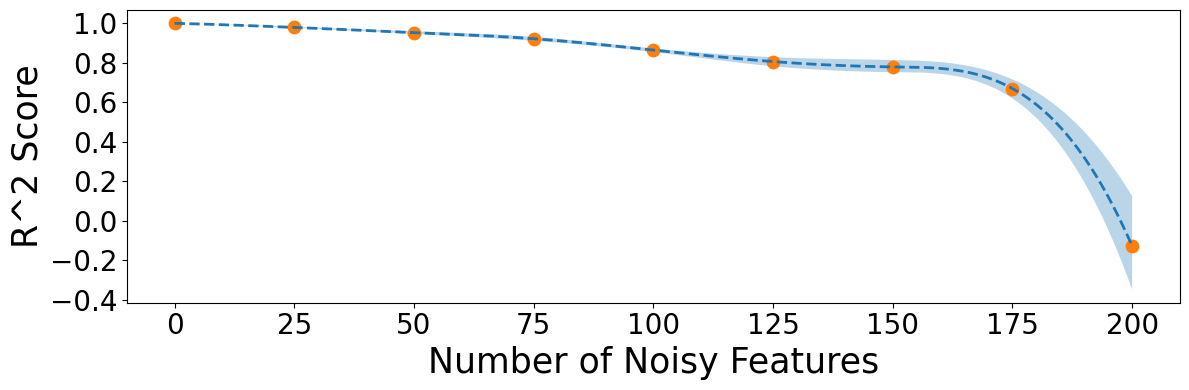

In [81]:
xa = np.array(num_features_options)-1
ya = np.mean(yas, axis=0)
yat = np.max(yas, axis=0)
yab = np.min(yas, axis=0)

xa_ya_Spline = make_interp_spline(xa, ya)
xa_yat_Spline = make_interp_spline(xa, yat)
xa_yab_Spline = make_interp_spline(xa, yab)

xa_ = np.linspace(xa.min(), xa.max(), 500)
ya_ = xa_ya_Spline(xa_)
yat_ = xa_yat_Spline(xa_)
yab_ = xa_yab_Spline(xa_)

plt.plot(xa_, ya_, '--', linewidth=2)
plt.fill_between(xa_, yab_, yat_, alpha=0.3)
plt.scatter(xa, ya, s=80, marker='o')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of Noisy Features", fontsize=25)
plt.ylabel("R^2 Score", fontsize=25)

plt.tight_layout()
plt.savefig("../preliminary_curve.png", dpi=300)
plt.show()

In [82]:
num_features_options = [1, 101, 201]

In [83]:
figure = plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

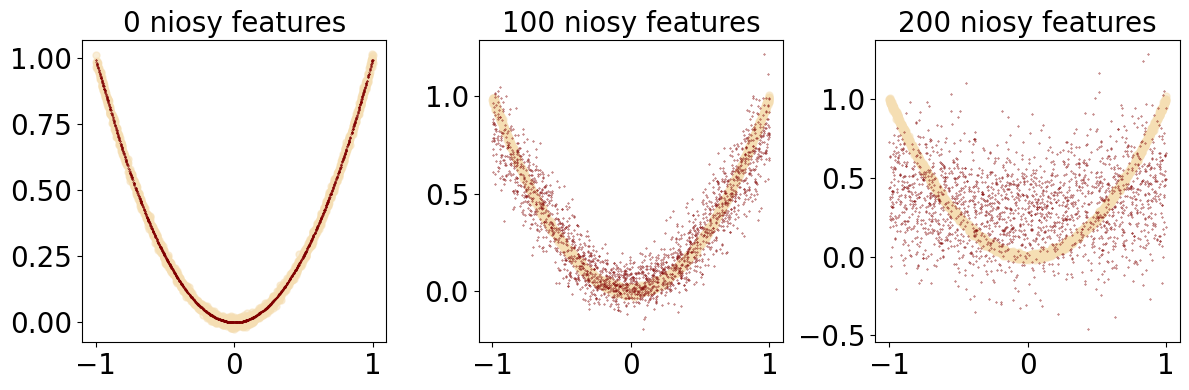

In [87]:
for ids, num_features in enumerate(num_features_options):
    X = (2*np.random.rand(num_data, num_features)-1)*X_var
    y_true = X[:, :1]**2
    y_noise = np.random.randn(num_data, 1)*y_var
    y = y_true+y_noise
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    regr = MLPRegressor(hidden_layer_sizes=(100,100,100), random_state=seed, max_iter=500).fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    score = regr.score(X_test, y_test)
    y_pred = np.expand_dims(y_pred, axis=1)
    
    ax = plt.subplot(1, 3, ids+1)
    ax.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
    ax.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(f"{num_features-1} niosy features", fontsize=20)

plt.tight_layout()
plt.savefig("../preliminary_short.png", dpi=300)
plt.show()